In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [2]:
from hiv_patient import HIVPatient
from buffer import Buffer

### Create dataset

In [3]:
patient = HIVPatient(clipping=False,logscale=False)

In [76]:
s = patient.reset()
dur = 400
nb_steps = int(dur//1e-3)
print(nb_steps)
states = [s]
for i in range(nb_steps):
    s1 = s + patient.der(s,patient.action_set[0])*1e-3
    s = s1
    states.append(s)

399999


KeyboardInterrupt: 

In [4]:
s = patient.reset(mode="unhealthy")
s[5] *= .75
patient.E *= .75
dur = 80 # 400/5
nb_steps = int(dur//1e-3)
states = [s]
for i in range(dur):
    s, r, d, _ = patient.step(0)
    states.append(s)

In [5]:
FQI_buffer = Buffer(10000)


In [6]:
dur = 50 # 400/5
nb_steps = int(dur//1e-3)

for j in tqdm(range(5)):
    s = patient.reset(mode="unhealthy")
    for i in range(200):
        a = np.random.choice(4)
        s_, r, d, _ = patient.step(a)
        FQI_buffer.append(s,a,r,s_,d)
        s = s_



100%|██████████| 5/5 [02:11<00:00, 26.28s/it]


### FQI 

In [7]:
from sklearn.ensemble import RandomForestRegressor

In [90]:
a= np.array([[8],[6]])
b = np.array([0,2])
#C =np.concatenate((a,b),axis=1)
e,f= b
print(f)

2


In [8]:
from typing import Optional,List, Callable
from sklearn.base import BaseEstimator

def estimator_factory(*args, **kwargs):
    return RandomForestRegressor(*args, **kwargs)


def update(memory : Buffer,
    gamma : float = 0.98,
    estimator : Optional[BaseEstimator] = None,
    estimator_factory: Callable = estimator_factory):

    states, actions, rewards, next_state, done  = memory.get()
    actions = np.expand_dims(actions,axis=1)
    target = np.expand_dims(rewards,axis=1)
    #target = rewards

    if estimator is not None:
        q_values = np.zeros((len(rewards),4))
        for a in range(4):
            actions_ = a*np.ones((len(rewards),1))
            X = np.concatenate((next_state,actions_),axis=1)
            q_values[:,a] = estimator.predict(X)
            
        #print(f"q_values --> {q_values}")
        qmax = np.expand_dims(np.max(q_values,axis=1),axis=1)
        #print(f"Shape de qmax --> {qmax.shape}, Shape de target --> {target.shape}, Shape de done --> {done.shape}")
        target += gamma*qmax * (1 - np.expand_dims(done,axis=1))
        #print(f"Shape de target --> {target.shape}")

    if estimator is None:
        estimator = estimator_factory()


    print(f"States shape --> {states.shape}, actions shape --> {actions.shape},target{target.shape}")
    data = np.concatenate((states,actions),axis=1)
    print(f"Data shape --> {data.shape}")
    estimator.fit(data,target)


    return estimator






### Entraînement !

In [9]:
estimator = None

for j in tqdm(range(10)):

    s = patient.reset(mode="unhealthy")

    for step in range(200):
        
        if np.random.random()<0.15:
            action = np.random.choice(4)
        
        else:
            if estimator is not None:
                greedy = np.zeros((4,2))
                for a in range(4):
                    #print(f"States shape --> {np.expand_dims(s.T,axis=1).shape}, actions shape --> {np.expand_dims(np.array([a]),axis=1).shape}")
                    sta = np.expand_dims(s,axis=1)
                    act = np.expand_dims(np.array([a]),axis=1)
                    X = np.concatenate((sta,act),axis=0).T
                    #print((f"shape of X --> {X.shape}"))
                    q = estimator.predict(X)
                    #print(f'Q -->{q}')
                    greedy[a,0] , greedy[a,1] = a , q

                #print(greedy)
                action = greedy[np.argmax(greedy[:,0]),0]
            
            else:
                action = np.random.choice(4)


        s_, r, d, _ = patient.step(int(action))
        FQI_buffer.append(s,a,r,s_,d)
        s = s_

        if (step % 20 == 0):
            #print(step//10)
            estimator = update(FQI_buffer,estimator=estimator)


  0%|          | 0/200 [00:00<?, ?it/s]

States shape --> (1001, 6), actions shape --> (1001, 1),target(1001, 1)
Data shape --> (1001, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 10%|█         | 20/200 [00:09<01:07,  2.66it/s]

States shape --> (1021, 6), actions shape --> (1021, 1),target(1021, 1)
Data shape --> (1021, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 20%|██        | 40/200 [00:17<00:54,  2.92it/s]

States shape --> (1041, 6), actions shape --> (1041, 1),target(1041, 1)
Data shape --> (1041, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 30%|███       | 60/200 [00:28<01:17,  1.80it/s]

States shape --> (1061, 6), actions shape --> (1061, 1),target(1061, 1)
Data shape --> (1061, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 40%|████      | 80/200 [00:39<01:00,  1.99it/s]

States shape --> (1081, 6), actions shape --> (1081, 1),target(1081, 1)
Data shape --> (1081, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 50%|█████     | 100/200 [00:49<00:42,  2.35it/s]

States shape --> (1101, 6), actions shape --> (1101, 1),target(1101, 1)
Data shape --> (1101, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 60%|██████    | 120/200 [01:01<00:47,  1.67it/s]

States shape --> (1121, 6), actions shape --> (1121, 1),target(1121, 1)
Data shape --> (1121, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 70%|███████   | 140/200 [01:12<00:26,  2.27it/s]

States shape --> (1141, 6), actions shape --> (1141, 1),target(1141, 1)
Data shape --> (1141, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 80%|████████  | 160/200 [01:21<00:17,  2.24it/s]

States shape --> (1161, 6), actions shape --> (1161, 1),target(1161, 1)
Data shape --> (1161, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 90%|█████████ | 180/200 [01:33<00:11,  1.81it/s]

States shape --> (1181, 6), actions shape --> (1181, 1),target(1181, 1)
Data shape --> (1181, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
  0%|          | 0/200 [00:00<?, ?it/s]

States shape --> (1201, 6), actions shape --> (1201, 1),target(1201, 1)
Data shape --> (1201, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 10%|█         | 20/200 [00:09<01:28,  2.03it/s]

States shape --> (1221, 6), actions shape --> (1221, 1),target(1221, 1)
Data shape --> (1221, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 20%|██        | 40/200 [00:19<01:36,  1.65it/s]

States shape --> (1241, 6), actions shape --> (1241, 1),target(1241, 1)
Data shape --> (1241, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 30%|███       | 60/200 [00:29<00:56,  2.47it/s]

States shape --> (1261, 6), actions shape --> (1261, 1),target(1261, 1)
Data shape --> (1261, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 40%|████      | 80/200 [00:40<00:53,  2.24it/s]

States shape --> (1281, 6), actions shape --> (1281, 1),target(1281, 1)
Data shape --> (1281, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 50%|█████     | 100/200 [00:47<00:22,  4.44it/s]

States shape --> (1301, 6), actions shape --> (1301, 1),target(1301, 1)
Data shape --> (1301, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 60%|██████    | 120/200 [00:57<00:19,  4.16it/s]

States shape --> (1321, 6), actions shape --> (1321, 1),target(1321, 1)
Data shape --> (1321, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 70%|███████   | 140/200 [01:13<00:21,  2.83it/s]

States shape --> (1341, 6), actions shape --> (1341, 1),target(1341, 1)
Data shape --> (1341, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 80%|████████  | 160/200 [01:22<00:09,  4.33it/s]

States shape --> (1361, 6), actions shape --> (1361, 1),target(1361, 1)
Data shape --> (1361, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 90%|█████████ | 180/200 [01:32<00:07,  2.77it/s]

States shape --> (1381, 6), actions shape --> (1381, 1),target(1381, 1)
Data shape --> (1381, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
  0%|          | 0/200 [00:00<?, ?it/s]

States shape --> (1401, 6), actions shape --> (1401, 1),target(1401, 1)
Data shape --> (1401, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 10%|█         | 20/200 [00:08<00:50,  3.56it/s]

States shape --> (1421, 6), actions shape --> (1421, 1),target(1421, 1)
Data shape --> (1421, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 20%|██        | 40/200 [00:18<00:47,  3.40it/s]

States shape --> (1441, 6), actions shape --> (1441, 1),target(1441, 1)
Data shape --> (1441, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 30%|███       | 60/200 [00:26<00:40,  3.49it/s]

States shape --> (1461, 6), actions shape --> (1461, 1),target(1461, 1)
Data shape --> (1461, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 40%|████      | 80/200 [00:35<00:35,  3.37it/s]

States shape --> (1481, 6), actions shape --> (1481, 1),target(1481, 1)
Data shape --> (1481, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 50%|█████     | 100/200 [00:44<00:40,  2.49it/s]

States shape --> (1501, 6), actions shape --> (1501, 1),target(1501, 1)
Data shape --> (1501, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 60%|██████    | 120/200 [00:52<00:40,  1.99it/s]

States shape --> (1521, 6), actions shape --> (1521, 1),target(1521, 1)
Data shape --> (1521, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 70%|███████   | 140/200 [01:01<00:26,  2.26it/s]

States shape --> (1541, 6), actions shape --> (1541, 1),target(1541, 1)
Data shape --> (1541, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 80%|████████  | 160/200 [01:11<00:14,  2.76it/s]

States shape --> (1561, 6), actions shape --> (1561, 1),target(1561, 1)
Data shape --> (1561, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 90%|█████████ | 180/200 [01:20<00:06,  3.09it/s]

States shape --> (1581, 6), actions shape --> (1581, 1),target(1581, 1)
Data shape --> (1581, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
  0%|          | 0/200 [00:00<?, ?it/s]

States shape --> (1601, 6), actions shape --> (1601, 1),target(1601, 1)
Data shape --> (1601, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 10%|█         | 20/200 [00:11<01:04,  2.81it/s]

States shape --> (1621, 6), actions shape --> (1621, 1),target(1621, 1)
Data shape --> (1621, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 20%|██        | 40/200 [00:20<00:49,  3.21it/s]

States shape --> (1641, 6), actions shape --> (1641, 1),target(1641, 1)
Data shape --> (1641, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 30%|███       | 60/200 [00:28<00:46,  3.04it/s]

States shape --> (1661, 6), actions shape --> (1661, 1),target(1661, 1)
Data shape --> (1661, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 40%|████      | 80/200 [00:36<00:36,  3.31it/s]

States shape --> (1681, 6), actions shape --> (1681, 1),target(1681, 1)
Data shape --> (1681, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 50%|█████     | 100/200 [00:45<00:29,  3.35it/s]

States shape --> (1701, 6), actions shape --> (1701, 1),target(1701, 1)
Data shape --> (1701, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 60%|██████    | 120/200 [00:53<00:25,  3.14it/s]

States shape --> (1721, 6), actions shape --> (1721, 1),target(1721, 1)
Data shape --> (1721, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 70%|███████   | 140/200 [01:03<00:19,  3.06it/s]

States shape --> (1741, 6), actions shape --> (1741, 1),target(1741, 1)
Data shape --> (1741, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 80%|████████  | 160/200 [01:12<00:17,  2.32it/s]

States shape --> (1761, 6), actions shape --> (1761, 1),target(1761, 1)
Data shape --> (1761, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 90%|█████████ | 180/200 [01:22<00:08,  2.47it/s]

States shape --> (1781, 6), actions shape --> (1781, 1),target(1781, 1)
Data shape --> (1781, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
  0%|          | 0/200 [00:00<?, ?it/s]

States shape --> (1801, 6), actions shape --> (1801, 1),target(1801, 1)
Data shape --> (1801, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 10%|█         | 20/200 [00:09<01:00,  2.97it/s]

States shape --> (1821, 6), actions shape --> (1821, 1),target(1821, 1)
Data shape --> (1821, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 20%|██        | 40/200 [00:19<01:00,  2.66it/s]

States shape --> (1841, 6), actions shape --> (1841, 1),target(1841, 1)
Data shape --> (1841, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 30%|███       | 60/200 [00:28<00:46,  3.04it/s]

States shape --> (1861, 6), actions shape --> (1861, 1),target(1861, 1)
Data shape --> (1861, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 40%|████      | 80/200 [00:38<00:46,  2.60it/s]

States shape --> (1881, 6), actions shape --> (1881, 1),target(1881, 1)
Data shape --> (1881, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 50%|█████     | 100/200 [00:48<00:31,  3.21it/s]

States shape --> (1901, 6), actions shape --> (1901, 1),target(1901, 1)
Data shape --> (1901, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 60%|██████    | 120/200 [00:58<00:30,  2.66it/s]

States shape --> (1921, 6), actions shape --> (1921, 1),target(1921, 1)
Data shape --> (1921, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 70%|███████   | 140/200 [01:08<00:18,  3.17it/s]

States shape --> (1941, 6), actions shape --> (1941, 1),target(1941, 1)
Data shape --> (1941, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 80%|████████  | 160/200 [01:17<00:12,  3.09it/s]

States shape --> (1961, 6), actions shape --> (1961, 1),target(1961, 1)
Data shape --> (1961, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 90%|█████████ | 180/200 [01:27<00:06,  3.29it/s]

States shape --> (1981, 6), actions shape --> (1981, 1),target(1981, 1)
Data shape --> (1981, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
  0%|          | 0/200 [00:00<?, ?it/s]

States shape --> (2001, 6), actions shape --> (2001, 1),target(2001, 1)
Data shape --> (2001, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 10%|█         | 20/200 [00:08<01:09,  2.58it/s]

States shape --> (2021, 6), actions shape --> (2021, 1),target(2021, 1)
Data shape --> (2021, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 20%|██        | 40/200 [00:19<00:54,  2.93it/s]

States shape --> (2041, 6), actions shape --> (2041, 1),target(2041, 1)
Data shape --> (2041, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 30%|███       | 60/200 [00:27<00:35,  3.91it/s]

States shape --> (2061, 6), actions shape --> (2061, 1),target(2061, 1)
Data shape --> (2061, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 40%|████      | 80/200 [00:35<00:30,  3.90it/s]

States shape --> (2081, 6), actions shape --> (2081, 1),target(2081, 1)
Data shape --> (2081, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 50%|█████     | 100/200 [00:46<00:22,  4.38it/s]

States shape --> (2101, 6), actions shape --> (2101, 1),target(2101, 1)
Data shape --> (2101, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 60%|██████    | 120/200 [00:53<00:22,  3.61it/s]

States shape --> (2121, 6), actions shape --> (2121, 1),target(2121, 1)
Data shape --> (2121, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 70%|███████   | 140/200 [01:04<00:25,  2.36it/s]

States shape --> (2141, 6), actions shape --> (2141, 1),target(2141, 1)
Data shape --> (2141, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 80%|████████  | 160/200 [01:14<00:12,  3.31it/s]

States shape --> (2161, 6), actions shape --> (2161, 1),target(2161, 1)
Data shape --> (2161, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 90%|█████████ | 180/200 [01:28<00:13,  1.54it/s]

States shape --> (2181, 6), actions shape --> (2181, 1),target(2181, 1)
Data shape --> (2181, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
  0%|          | 0/200 [00:00<?, ?it/s]

States shape --> (2201, 6), actions shape --> (2201, 1),target(2201, 1)
Data shape --> (2201, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 10%|█         | 20/200 [00:12<00:52,  3.40it/s]

States shape --> (2221, 6), actions shape --> (2221, 1),target(2221, 1)
Data shape --> (2221, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 20%|██        | 40/200 [00:28<01:08,  2.32it/s]

States shape --> (2241, 6), actions shape --> (2241, 1),target(2241, 1)
Data shape --> (2241, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 30%|███       | 60/200 [00:38<00:34,  4.01it/s]

States shape --> (2261, 6), actions shape --> (2261, 1),target(2261, 1)
Data shape --> (2261, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 40%|████      | 80/200 [00:46<00:31,  3.82it/s]

States shape --> (2281, 6), actions shape --> (2281, 1),target(2281, 1)
Data shape --> (2281, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 50%|█████     | 100/200 [00:53<00:25,  3.85it/s]

States shape --> (2301, 6), actions shape --> (2301, 1),target(2301, 1)
Data shape --> (2301, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 60%|██████    | 120/200 [01:01<00:19,  4.20it/s]

States shape --> (2321, 6), actions shape --> (2321, 1),target(2321, 1)
Data shape --> (2321, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 70%|███████   | 140/200 [01:10<00:13,  4.51it/s]

States shape --> (2341, 6), actions shape --> (2341, 1),target(2341, 1)
Data shape --> (2341, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 80%|████████  | 160/200 [01:18<00:09,  4.25it/s]

States shape --> (2361, 6), actions shape --> (2361, 1),target(2361, 1)
Data shape --> (2361, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 90%|█████████ | 180/200 [01:26<00:05,  3.91it/s]

States shape --> (2381, 6), actions shape --> (2381, 1),target(2381, 1)
Data shape --> (2381, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
  0%|          | 0/200 [00:00<?, ?it/s]

States shape --> (2401, 6), actions shape --> (2401, 1),target(2401, 1)
Data shape --> (2401, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 10%|█         | 20/200 [00:08<00:47,  3.77it/s]

States shape --> (2421, 6), actions shape --> (2421, 1),target(2421, 1)
Data shape --> (2421, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 20%|██        | 40/200 [00:16<00:46,  3.44it/s]

States shape --> (2441, 6), actions shape --> (2441, 1),target(2441, 1)
Data shape --> (2441, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 30%|███       | 60/200 [00:25<00:39,  3.54it/s]

States shape --> (2461, 6), actions shape --> (2461, 1),target(2461, 1)
Data shape --> (2461, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 40%|████      | 80/200 [00:34<00:41,  2.89it/s]

States shape --> (2481, 6), actions shape --> (2481, 1),target(2481, 1)
Data shape --> (2481, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 50%|█████     | 100/200 [00:44<00:32,  3.05it/s]

States shape --> (2501, 6), actions shape --> (2501, 1),target(2501, 1)
Data shape --> (2501, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 60%|██████    | 120/200 [00:53<00:16,  4.86it/s]

States shape --> (2521, 6), actions shape --> (2521, 1),target(2521, 1)
Data shape --> (2521, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 70%|███████   | 140/200 [01:03<00:19,  3.01it/s]

States shape --> (2541, 6), actions shape --> (2541, 1),target(2541, 1)
Data shape --> (2541, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 80%|████████  | 160/200 [01:12<00:11,  3.39it/s]

States shape --> (2561, 6), actions shape --> (2561, 1),target(2561, 1)
Data shape --> (2561, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 90%|█████████ | 180/200 [01:20<00:05,  3.42it/s]

States shape --> (2581, 6), actions shape --> (2581, 1),target(2581, 1)
Data shape --> (2581, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
  0%|          | 0/200 [00:00<?, ?it/s]

States shape --> (2601, 6), actions shape --> (2601, 1),target(2601, 1)
Data shape --> (2601, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 10%|█         | 20/200 [00:10<00:56,  3.17it/s]

States shape --> (2621, 6), actions shape --> (2621, 1),target(2621, 1)
Data shape --> (2621, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 20%|██        | 40/200 [00:19<00:48,  3.31it/s]

States shape --> (2641, 6), actions shape --> (2641, 1),target(2641, 1)
Data shape --> (2641, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 30%|███       | 60/200 [00:30<00:49,  2.80it/s]

States shape --> (2661, 6), actions shape --> (2661, 1),target(2661, 1)
Data shape --> (2661, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 40%|████      | 80/200 [00:40<00:34,  3.44it/s]

States shape --> (2681, 6), actions shape --> (2681, 1),target(2681, 1)
Data shape --> (2681, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 50%|█████     | 100/200 [00:51<00:34,  2.87it/s]

States shape --> (2701, 6), actions shape --> (2701, 1),target(2701, 1)
Data shape --> (2701, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 60%|██████    | 120/200 [01:01<00:30,  2.60it/s]

States shape --> (2721, 6), actions shape --> (2721, 1),target(2721, 1)
Data shape --> (2721, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 70%|███████   | 140/200 [01:12<00:21,  2.83it/s]

States shape --> (2741, 6), actions shape --> (2741, 1),target(2741, 1)
Data shape --> (2741, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 80%|████████  | 160/200 [01:22<00:13,  2.99it/s]

States shape --> (2761, 6), actions shape --> (2761, 1),target(2761, 1)
Data shape --> (2761, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 90%|█████████ | 180/200 [01:33<00:07,  2.68it/s]

States shape --> (2781, 6), actions shape --> (2781, 1),target(2781, 1)
Data shape --> (2781, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
  0%|          | 0/200 [00:00<?, ?it/s]

States shape --> (2801, 6), actions shape --> (2801, 1),target(2801, 1)
Data shape --> (2801, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 10%|█         | 20/200 [00:10<00:54,  3.28it/s]

States shape --> (2821, 6), actions shape --> (2821, 1),target(2821, 1)
Data shape --> (2821, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 20%|██        | 40/200 [00:23<01:00,  2.63it/s]

States shape --> (2841, 6), actions shape --> (2841, 1),target(2841, 1)
Data shape --> (2841, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 30%|███       | 60/200 [00:34<00:56,  2.47it/s]

States shape --> (2861, 6), actions shape --> (2861, 1),target(2861, 1)
Data shape --> (2861, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 40%|████      | 80/200 [00:45<00:54,  2.18it/s]

States shape --> (2881, 6), actions shape --> (2881, 1),target(2881, 1)
Data shape --> (2881, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 50%|█████     | 100/200 [01:01<00:50,  1.99it/s]

States shape --> (2901, 6), actions shape --> (2901, 1),target(2901, 1)
Data shape --> (2901, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 60%|██████    | 120/200 [01:17<00:33,  2.41it/s]

States shape --> (2921, 6), actions shape --> (2921, 1),target(2921, 1)
Data shape --> (2921, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 70%|███████   | 140/200 [01:40<00:43,  1.38it/s]

States shape --> (2941, 6), actions shape --> (2941, 1),target(2941, 1)
Data shape --> (2941, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 80%|████████  | 160/200 [01:59<00:13,  2.92it/s]

States shape --> (2961, 6), actions shape --> (2961, 1),target(2961, 1)
Data shape --> (2961, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
 90%|█████████ | 180/200 [02:07<00:05,  3.44it/s]

States shape --> (2981, 6), actions shape --> (2981, 1),target(2981, 1)
Data shape --> (2981, 7)


/tmp/ipykernel_11660/2817282500.py:38: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(data,target)
100%|██████████| 200/200 [02:17<00:00,  1.46it/s]


### Affichons les résultats

In [10]:

s = patient.reset(mode="unhealthy")
T1,T2,T1_,T2_,V,E = np.zeros(200), np.zeros(200), np.zeros(200), np.zeros(200), np.zeros(200), np.zeros(200)

for step in tqdm(range(200)):
    T1[step], T2[step], T1_[step], T2_[step], V[step], E[step] = s 

    greedy = np.zeros((4,2))
        
    for a in range(4):
                    #print(f"States shape --> {np.expand_dims(s.T,axis=1).shape}, actions shape --> {np.expand_dims(np.array([a]),axis=1).shape}")
        sta = np.expand_dims(s,axis=1)
        act = np.expand_dims(np.array([a]),axis=1)
        X = np.concatenate((sta,act),axis=0).T
                    #print((f"shape of X --> {X.shape}"))
        q = estimator.predict(X)
                    #print(f'Q -->{q}')
        greedy[a,0] , greedy[a,1] = a , q

                #print(greedy)
        action = greedy[np.argmax(greedy[:,0]),0]
            


    s_, r, d, _ = patient.step(int(action))
    FQI_buffer.append(s,a,r,s_,d)
    s = s_

100%|██████████| 200/200 [01:15<00:00,  2.64it/s]


Post traitement

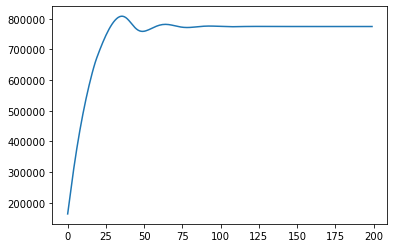

In [12]:
plt.plot(T1)

In [97]:
FQI_buffer.get()

/home/abfaria/AML/reinforcement-learning/hiv_experiment/buffer.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  actions = np.array(self.actions)


(array([[1.63573000e+05, 1.19450000e+04, 5.00000000e+00, 4.60000000e+01,
         6.39190000e+04, 2.40000000e+01],
        [1.63572059e+05, 1.19450569e+04, 4.99536372e+00, 4.56109782e+01,
         6.39192996e+04, 2.39127429e+01],
        [1.63572408e+05, 1.19447342e+04, 4.99550528e+00, 4.55991397e+01,
         6.39175048e+04, 2.38422009e+01],
        ...,
        [3.05913320e+05, 4.23622772e+03, 1.98900858e+01, 3.88257597e+01,
         1.65420084e+04, 8.13881480e+01],
        [1.63573000e+05, 1.19450000e+04, 5.00000000e+00, 4.60000000e+01,
         6.39190000e+04, 2.40000000e+01],
        [1.63573000e+05, 1.19450000e+04, 5.00000000e+00, 4.60000000e+01,
         6.39190000e+04, 2.40000000e+01]]),
 array([0, 0, 1, ..., 1, array([[8],
                                [6]]), array([[8],
                                              [6]])], dtype=object),
 array([17608.1       , 17520.81290441, 15650.45039034, ...,
        77933.94719159, 15808.1       , 15808.1       ]),
 array([[1.63572059

In [98]:
np.array(FQI_buffer.actions).shape

/tmp/ipykernel_3942/2065286334.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(FQI_buffer.actions).shape


(6002,)

In [80]:
_, _, rewards, _, _  = FQI_buffer.get()